## Final Predictions Workflow Notebook v1

#### Sources of information, code and discussions

1. This notebook follows the 5 step process presented in the Chris Deotte "How to compete with GPUs Workshop" [here][1].
2. Triple stratified KFold TFRecords used for image data is explained [here][2].
3. Some code sections have been reused from AgentAuers' notebook [here][3]
4. The advantage of using different input sizes is discussed [here][4]
5. Use external data by changing the variables `INC2019` and `INC2018`.These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][5]

[1]: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
[3]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[4]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147
[5]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

####  Initiatialise environment and import necessary libraries

# Initialize Environment

In [1]:
# Use if running in Kaggle environment
#!pip install -q efficientnet >> /dev/null

In [2]:
# import KaggleDatasets if running in Kaggle environment
#from kaggle_datasets import KaggleDatasets

import os, re, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score 
from sklearn.utils import class_weight

## Configuration

* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 for conistent number of train and validation samples across folds
* IMG_SIZES - These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter. Consider early stopping in Callbacks.
* EFF_NETS - These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

Image sizes used in the Efficientnet model:

- efficientnet-b0-224 -cv train with 192
- efficientnet-b1-240 -cv train with 256
- efficientnet-b2-260 -cv train with 256
- efficientnet-b3-300 -cv train with 384
- efficientnet-b4-380 -cv train with 384
- efficientnet-b5-456 -cv train with 512
- efficientnet-b6-528 -cv train with 512
- efficientnet-b7-600 -cv train with 768

Better to train with a larger size and let the model scale down rather than up.

In [3]:
ENV = "LOCAL" #or "KAGGLE"

# DEFAULT TO TPU TO ENSURE KAGGLE TPU COMPATIABILITY
# https://www.kaggle.com/docs/tpu
DEVICE = "TPU" #or "GPU"

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = 256

# META DATA? YES=1 NO=0
META = 1

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = 0
INC2018 = 1

# UPSAMPLE MALIGNANT
M1 = 1 #2020 malig
M2 = 1 #ISIC malig
M3 = 1 #2019 good malig
M4 = 1 #2018 2017 malig - Malignant only images from HAM10000

# COARSE DROPOUT
DROP_FREQ = 0 # 0.75 # between 0 and 1
DROP_CT = 0 # 8 # may slow training if CT>16
DROP_SIZE = 0 # 0.2 # between 0 and 1

# BATCH SIZE AND EPOCHS
# TRY 8, 16, 32, 64, 128, 256. REDUCE IF OOM ERROR, HIGHER FOR TPUS
BATCH_SIZES = 32
EPOCHS = 35

# METADATA ENSEMBLE
META_ENSEMBLE = 1 # 1 = Yes, 0 = No
META_WEIGHT = 0.03 # Optimal weight to use in Ensemble

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = 1

# TEST TIME AUGMENTATION STEPS
TTA = 25

#### Configure environment to use TPUs, Multiple GPUs, Single GPU or just CPU

In [4]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and GPU")
    

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    if len(tf.config.experimental.list_physical_devices('GPU')) > 1:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy()
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and GPU
Num GPUs Available:  2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
REPLICAS: 2


### Step 1: Preprocess and file handling
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section.

In [5]:
# Load file locations
if ENV == 'KAGGLE':
    #Use GCS if running in Kaggle environment
    PATH = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(IMG_SIZES,IMG_SIZES))
    PATH2 = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(IMG_SIZES,IMG_SIZES))
    PATH3 = KaggleDatasets().get_gcs_path('malignant-v2-%ix%i'%(IMG_SIZES,IMG_SIZES))
    files_train = np.sort(np.array(tf.io.gfile.glob(PATH + '/train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(PATH + '/test*.tfrec')))
       
if ENV == 'LOCAL':  
    # Use LDS if running in local environment
    PATH = None; PATH2 = None; PATH3 = None
    PATH = f"./siim-isic-melanoma-classification/tfrecords{IMG_SIZES}"
    PATH2 = f"./siim-isic-melanoma-classification/tfrecords{IMG_SIZES}Ext"
    PATH3 = f"./siim-isic-melanoma-classification/tfrecords{IMG_SIZES}Mal"
    files_train = np.sort(np.array(tf.io.gfile.glob(PATH + '/train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(PATH + '/test*.tfrec')))

In [6]:
# Save file locations
if ENV == 'KAGGLE':
    LOG_PATH = ''
    CV_OOF_PREDS_PATH = ''
    CV_TEST_PREDS_PATH = ''
    CV_FOLDS_PATH = ''

if ENV == 'LOCAL':
    LOG_PATH = './logs/'
    CV_OOF_PREDS_PATH = './cv_oof_preds/'
    CV_TEST_PREDS_PATH = './cv_test_preds/'
    CV_FOLDS_PATH = './cv_folds/'

In [7]:
# File handling functions
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_meta_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image_name'], example['sex'], example['age_approx'], example['anatom_site_general_challenge'], example['target']

def read_meta_tfrecord_test(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image_name'], example['sex'], example['age_approx'], example['anatom_site_general_challenge']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [8]:
# Function to stream datasets into model when training, validating and predicting
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256,
                droprate=0, dropct=0, dropsize=0):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim,
                                               droprate=droprate, dropct=dropct, dropsize=dropsize),
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [9]:
# Function to stream datasets into model when training, validating and predicting
column_names = ['image_name', 'sex', 'age_approx', 'anatom', 'target']
column_names_test = ['image_name', 'sex', 'age_approx', 'anatom']

def get_meta(files, batch_size=16, test=0):
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    if test:
        ds = ds.map(lambda example: read_meta_tfrecord_test(example), num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_meta_tfrecord(example), num_parallel_calls=AUTO)      
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
        
    return ds

def meta_unbatch(files, test=0):
    if test:
        meta_np = np.array([[img_name.numpy().decode("utf-8"),
                  sex.numpy(),
                  age.numpy(),
                  anatomy.numpy()]
                for img_name, sex, age, anatomy in iter(files.unbatch())])
        meta_df = pd.DataFrame(data = meta_np, columns=column_names_test)

    else:        
        meta_np = np.array([[img_name.numpy().decode("utf-8"),
                  sex.numpy(),
                  age.numpy(),
                  anatomy.numpy(),
                  target.numpy()] 
                for img_name, sex, age, anatomy, target in iter(files.unbatch())])
        
        meta_df = pd.DataFrame(data = meta_np, columns=column_names)
        meta_df = meta_df.astype({"target": int})
    return meta_df

### Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation. This notebook also uses horizontal flip, saturation, contrast, brightness augmentation similar to last years winner.

In [10]:
# Assign variables
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [11]:
def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [12]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

def prepare_image(img, augment=True, dim=256, droprate=0, dropct=0, dropsize=0):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        if (droprate!=0)&(dropct!=0)&(dropsize!=0): 
            img = dropout(img, DIM=dim, PROBABILITY=droprate, CT=dropct, SZ=dropsize)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

### Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN. Also consider different models to provide diversity of predictions which may benefit the final ensemble.

In [13]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=128, ef=0, v=0):
    inputs = tf.keras.layers.Input(shape=(dim,dim,3))
    
    base = EFNS[ef](input_shape=(dim,dim,3),weights='noisy-student',include_top=False)
    
    x = base(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    
    if v:
        model.summary()
    
    return model

# Visualise model in use
build_model(dim=IMG_SIZES,ef=EFF_NETS,v=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnet-b1 (Functional) (None, 8, 8, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 6,576,513
Trainable params: 6,514,465
Non-trainable params: 62,048
_________________________________________________________________


In [14]:
# META DATA FUNCTION

# Function to get meta data
def meta_model(meta_train, meta_val):
    L = 15
    feat = ['sex','age_approx','anatom']
    M = meta_train.target.mean()
    te = meta_train.groupby(feat)['target'].agg(['mean','count']).reset_index()
    te['ll'] = ((te['mean']*te['count'])+(M*L))/(te['count']+L)
    del te['mean'], te['count']
    meta_val = meta_val.merge( te, on=feat, how='left' )
    meta_val['ll'] = meta_val['ll'].fillna(M)
    return meta_val


### Step 4: Training

#### Training Schedule
Thism is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [15]:
TS_CFG = dict(
    lr_start   = 0.000006, 
    lr_max     = 0.00000145 * REPLICAS * BATCH_SIZES,
    lr_min     = 0.000001,
    lr_ramp_ep = 5,
    lr_sus_ep  = 0,
    lr_decay   = 0.85
    )

In [16]:
def get_lr_callback(ts_cfg, batch_size=8):
    lr_start   = ts_cfg['lr_start']
    lr_max     = ts_cfg['lr_max']
    lr_min     = ts_cfg['lr_min']
    lr_ramp_ep = ts_cfg['lr_ramp_ep']
    lr_sus_ep  = ts_cfg['lr_sus_ep']
    lr_decay   = ts_cfg['lr_decay']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    
    return lr_callback

#### Visualise Training Schedule

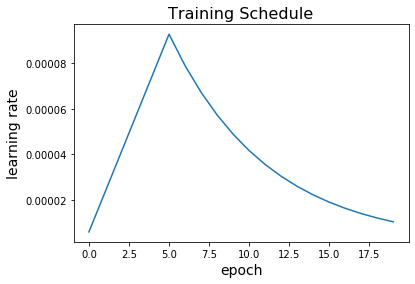

In [17]:
# Quick test and visualisation of learning rate schedule
# Important not to have a high learning rate which would destroy the pre-trained parameters
lr_start   = TS_CFG['lr_start']
lr_max     = TS_CFG['lr_max']
lr_min     = TS_CFG['lr_min']
lr_ramp_ep = TS_CFG['lr_ramp_ep']
lr_sus_ep  = TS_CFG['lr_sus_ep']
lr_decay   = TS_CFG['lr_decay']

def lrfn_sched(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

# Visualise learning rate schedule
rng = [i for i in range(20)]
y = [lrfn_sched(x) for x in rng]
plt.plot(rng, y)
plt.xlabel('epoch', size=14); plt.ylabel('learning rate', size=14)
plt.title('Training Schedule', size=16); plt.show()

#### Class Imbalance Analysis

In [18]:
# Analyze class imbalance in the targets
# Number of positive samples in training data: 470 (1.77% of total 33126)
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / (33126-470))*(33126)/2.0 
weight_for_1 = (1 / 470)*(33126)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 35.24


#### Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [19]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True
    
# DISPLAY FOLD INFO
if DEVICE=='TPU':
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)

print('#'*25)
print(f'#### Image Size {IMG_SIZES} with EfficientNet B{EFF_NETS} and batch_size {BATCH_SIZES*REPLICAS}')
print(f'#### DropoutFreq {DROP_FREQ} Count {DROP_CT} Size {DROP_SIZE}')
print('#'*25)

#########################
#### Image Size 256 with EfficientNet B1 and batch_size 64
#### DropoutFreq 0 Count 0 Size 0
#########################


In [20]:
# CREATE TRAIN INDEX LIST
idxT = np.asarray([x for x in range(0,15,1)])

In [21]:
# CREATE TRAIN SET FROM VARIOUS SELECTED SOURCES
print('#'*25)
files_train = tf.io.gfile.glob([PATH + '/train%.2i*.tfrec'%x for x in idxT])
if INC2019:
    files_train += tf.io.gfile.glob([PATH2 + '/train%.2i*.tfrec'%x for x in idxT*2+1])
    print('#### Using 2019 external data')
if INC2018:
    files_train += tf.io.gfile.glob([PATH2 + '/train%.2i*.tfrec'%x for x in idxT*2])
    print('#### Using 2018+2017 external data')
if M1:
    files_train += tf.io.gfile.glob([PATH3 + '/train%.2i*.tfrec'%x for x in idxT])
    print('#### Upsample MALIG-1 data (2020 comp)')
if M2:
    files_train += tf.io.gfile.glob([PATH3 + '/train%.2i*.tfrec'%x for x in idxT+15])
    print('#### Upsample MALIG-2 data (ISIC website)')
if M3:
    files_train += tf.io.gfile.glob([PATH3 + '/train%.2i*.tfrec'%x for x in idxT*2+1+30])
    print('#### Upsample MALIG-3 data (2019 comp)')
if M4:
    files_train += tf.io.gfile.glob([PATH3 + '/train%.2i*.tfrec'%x for x in idxT*2+30])
    print('#### Upsample MALIG-4 data (2018 2017 comp)')        
np.random.shuffle(files_train)
print('#'*25)

# CREATE TEST SET
files_test = np.sort(np.array(tf.io.gfile.glob(PATH + '/test*.tfrec')))

#########################
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################


In [22]:
# DETERMINE CLASS WEIGHTS FROM TRAINING DATASET
# Analyze class imbalance in the targets
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
ft = get_dataset(files_train, augment=False, repeat=False, dim=IMG_SIZES,
        labeled=True, return_image_names=True)
ott = np.array([target.numpy() for img, target in iter(ft.unbatch())])
tot = len(ott)
counts = np.bincount(ott[:])

weight_for_0 = (1 / counts[0])*(tot)/2.0 
weight_for_1 = (1 / counts[1])*(tot)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('#'*25)
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('#'*25)

#########################
Weight for class 0: 0.57
Weight for class 1: 3.89
#########################


In [23]:
# BUILD MODEL
K.clear_session()
with strategy.scope():
    model = build_model(dim=IMG_SIZES,ef=EFF_NETS,v=1)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [24]:
# CALLBACKS - SAVE MODEL WEIGHTS AT EACH EPOCH
WEIGHTS_FILE = f'{CV_FOLDS_PATH}EB{EFF_NETS}-{IMG_SIZES}-final.h5'
svw = tf.keras.callbacks.ModelCheckpoint(WEIGHTS_FILE,
                                         verbose=1,
                                         save_weights_only=True)

callback_list = [svw, get_lr_callback(TS_CFG, BATCH_SIZES)]

In [ ]:
# TRAIN
# Use // on REPLICAS to divide with integral result (discard remainder)
print('Training...')
history = model.fit(
    get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES, batch_size = BATCH_SIZES,
                droprate=DROP_FREQ, dropct=DROP_CT, dropsize=DROP_SIZE),
    epochs=EPOCHS,
    callbacks = callback_list, 
    steps_per_epoch=count_data_items(files_train)/BATCH_SIZES//REPLICAS,
    class_weight=class_weight,
    verbose=VERBOSE
)

Training...
Epoch 1/35
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 301 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 301 all-reduces with algorithm = nccl, num_packs = 1
748/748 [==============================] - ETA: 0s - loss: 0.5776 - auc: 0.8121
Epoch 00001: saving model to ./cv_folds/EB1-256-final.h5
748/748 [==============================] - 242s 323ms/step - loss: 0.5776 - auc: 0.8121
Epoch 2/35
143/748 [====>.........................] - ETA: 3:13 - loss: 0.4231 - auc: 0.8931

In [ ]:
# RELOAD WEIGHTS
print('#'*25)
print('Loading weights...')
model.load_weights(WEIGHTS_FILE)
print('Done.')
print('#'*25)

In [ ]:
# PREDICT TEST USING TTA
preds = np.zeros((count_data_items(files_test),1))

print('#'*25)
print('Predicting Test with TTA...')
ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
                     repeat=True,shuffle=False,dim=IMG_SIZES,batch_size=BATCH_SIZES*4,
                     droprate=DROP_FREQ, dropct=DROP_CT, dropsize=DROP_SIZE)

ct_test = count_data_items(files_test)
print('Number of test samples:', ct_test)
STEPS = TTA * ct_test/BATCH_SIZES/4/REPLICAS
print('Number of steps in prediction:', STEPS)
pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,]
pred = np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1)
preds[:,0] += pred
print('#'*25)

In [ ]:
# ENSEMBLE USING METADATA PROBABILITY MODEL
preds_meta_ls = np.zeros((count_data_items(files_test),1))

if META_ENSEMBLE:
    print('#'*25)
    print("Performing ensemble of image predictions with metadata probability model using meta weight of:", META_WEIGHT)

    dsp_ft = get_meta(files_train)
    meta_train = meta_unbatch(dsp_ft)

    ds_test_meta = get_meta(files_test, BATCH_SIZES, test=1)
    meta_test = meta_unbatch(ds_test_meta, test=1)
    meta_test = meta_model(meta_train, meta_test)

    meta_test['preds'] = pred
    meta_test['preds_meta'] = META_WEIGHT*meta_test.ll + (1-META_WEIGHT)*meta_test.preds

    preds_meta = np.array([meta_test.preds_meta]).T
    preds_meta_ls += preds_meta
    print('#'*25)

In [ ]:
# PLOT TRAINING
COMPLETED_EPOCHS = len(history.history['loss'])
if DISPLAY_PLOT:
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(COMPLETED_EPOCHS),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    x = np.argmax( history.history['auc'] )
    y = np.max( history.history['auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(COMPLETED_EPOCHS),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    x = np.argmin( history.history['loss'] )
    y = np.min( history.history['loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i, M1=%i, M2=%i, M3=%i, M4=%i\n\
    batch_size %i, dropout_freq=%.2f count=%i size=%.3f'%
            (IMG_SIZES,EFF_NETS,INC2019,INC2018,M1,M2,M3,
             M4,BATCH_SIZES*REPLICAS,DROP_FREQ,DROP_CT,DROP_SIZE),size=18)
    plt.legend(loc=3)
    plt.show()  

### Prepare Kaggle File

In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES,
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv(f'{CV_TEST_PREDS_PATH}EB{EFF_NETS}-{IMG_SIZES}-FINAL-submission.csv', index=False)
submission.head()

In [ ]:
submission_meta = pd.DataFrame(dict(image_name=image_names, target=preds_meta_ls[:,0]))
submission_meta = submission_meta.sort_values('image_name') 
submission_meta.to_csv(f'{CV_TEST_PREDS_PATH}EB{EFF_NETS}-{IMG_SIZES}-FINAL-META-submission.csv', index=False)
submission_meta.head()

In [ ]:
# PLOT DISTRIBUTION WITHOUT META
plt.hist(submission.target,bins=100)
plt.show()

In [ ]:
# PLOT DISTRIBUTION WITH META
plt.hist(submission_meta.target,bins=100)
plt.show()